Faulty bearings with known fault depth (0.007 inch, or 0.014 inch, or 0.021 inch) are installed in the motor and the resulting vibration signal is collected by accelerometers.

Accelerometers are placed at three locations of the motor: at the drive end (DE), fan end (FE) and base (BA).

Resulting time series data are collected with a sampling frequency of either 12k or 48k.

In the experiment, different amounts of (torsional) loads are applied to the motor. 

We have taken data with 1hp load and 48k sampling frequency for all our anlaysis and only the drive end data as they are closer to the faults which might help us get good analysis. 

In [1]:
import glob                               #For moving throug directories and returing paths too
from scipy.io import loadmat              #for reasing Matlab files
import numpy as np
import pandas as pd

In [2]:
files = glob.glob(r"C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data/*",  
                   recursive = True) 
for file in files: 
    print(file) 

C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data\B007_1_123.mat
C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data\B007_1_190.mat
C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data\B007_1_227.mat
C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data\IR007_1_110.mat
C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data\IR007_1_175.mat
C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data\IR007_1_214.mat
C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data\OR007_6_1_136.mat
C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data\OR007_6_1_202.mat
C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data\OR007_6_1_239.mat
C:\Users\Lenovo\Desktop\Bearing Fault\data\raw matlab data\Time_Normal_1_098.mat


In [3]:
check_data = loadmat(files[0])
type(check_data)

dict

In [4]:
check_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X123_DE_time', 'X123_FE_time', 'X123RPM'])

Keys of each file contain drive end signal (DE_time), fan end signal (FE_time), and in some cases base signal (BA). 

X123RPM gives RPM information. 

We will only take drive end data for our analysis. Drive ends are closer to the bearing. 

So we believe, it would give more reliable indication of fault. 

Thus, we have used only drive end data. 

We can get drive end data using its key.

In [5]:
drive_end_data = check_data["X123_DE_time"]
drive_end_data.shape

(487384, 1)

In [6]:
check_data_2 = loadmat(files[4])
check_data_2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X217', 'X217_DE_time', 'X175_DE_time', 'X175_FE_time', 'X175RPM'])

In [7]:
check_data_2['X217_DE_time']

array([[0.23782154],
       [0.20444308],
       [0.12141415],
       ...,
       [0.41368431],
       [0.46270892],
       [0.45311262]])

In [8]:
check_data_2['X175_FE_time']

array([[-0.07026545],
       [-0.02958545],
       [ 0.04006364],
       ...,
       [-0.05485636],
       [-0.03020182],
       [-0.01088909]])

In [9]:
check_data_2['X175RPM']

array([[1772]], dtype=uint16)

Of all the files in the folder, one file (IR014_1_175.mat) with index 4 is rather peculiar. 

It has following keys: 'X217', 'X217_DE_time', 'X175_DE_time', 'X175_FE_time', 'X175RPM'. '



In [10]:
a = check_data_2['X217_DE_time']
a.shape

(489125, 1)

In [11]:
b= check_data_2['X175_DE_time']
b.shape

(381890, 1)

We can clearly see 'X175_DE_time' contains less number of data points than we need for further analysis. 

So we have taken 'X217_DE_time' from this particular file for our anlaysis

                                     Preprocessing of Raw dat(CWRU)

We will be using feature based techniques for fault diagnosis. 

In feature based techniques, first relevant features are collected from the data. 

Features can be categorized as time domain features, frequency domain features or time-frequency domain features.


To compute time domain features, what we do is we segment our whole signal(raw) obtained into lengths of 1024 or 2048
without any overlap between them which would hopefully represent original data in a better way instead of taking 
whole signal at a go(in which we get only 8 features which is not at all enough to represent ourn whole data.)

So first, let's compute the maximum number of segments of length 1024 that we can extract from each file using only 
the drive end data .

In [12]:
for file in files:
    data = loadmat(file)
    if file[-7:-4] == "175":         # for the Peculiar IR014_1 data which had lesser data points in one of the DE data
        key = "X217_DE_time"
    else:
        key = "X" + file[-7:-4] + "_DE_time"
    drive_end_data = data[key]
    num_segments = np.floor(len(drive_end_data)/1024)
    print(num_segments)                                                  

475.0
474.0
475.0
474.0
477.0
473.0
475.0
473.0
477.0
472.0



We can clearly see we can extract at least 470 segments from each file.

In the processed data, we have taken first 460 segments from each file.

After extraction we will have our data of shape (4600*1024)

Now if we want to collect our time domain features, we can collect features taking each row of this data. 

For example, if we collect 8 time domain features for each segment, our feature matrix will have a shape of (4600*8)

Here, we will not compute features. 

We will just create a preprocessed data matrix of shape (4600*1024).



In [13]:
segmented_data = np.repeat(np.nan, 4600*1024).reshape(4600,1024)
num = 0
for file in files:
    data = loadmat(file)
    if file[-7:-4] == "175":    
        key = "X217_DE_time"
    else:
        key = "X" + file[-7:-4] + "_DE_time"
    drive_end_data = data[key]
    for i in range(460):           # We collect 460 segments from each file
        segmented_data[num,:] = drive_end_data[i*1024:(i+1)*1024, 0]
        num = num + 1

In [14]:
segmented_data

array([[-0.04109723, -0.046104  , -0.02837169, ...,  0.13601723,
         0.10138708,  0.06654831],
       [ 0.04839877,  0.04839877,  0.05090215, ..., -0.28601169,
        -0.15708738,  0.01293415],
       [ 0.18671077,  0.31876431,  0.39845538, ..., -0.22551323,
        -0.25367631, -0.22926831],
       ...,
       [-0.10555938, -0.07802215, -0.01564615, ..., -0.09658892,
        -0.11828492, -0.08115138],
       [-0.00250338,  0.05361415,  0.07489292, ...,  0.00730154,
         0.00646708, -0.02127877],
       [-0.04631262, -0.05528308, -0.03838523, ..., -0.06049846,
        -0.08574092, -0.10013538]])

We check whether the segmented_data contains any nan values or not.

In [15]:
np.sum(np.isnan(segmented_data))

0

In [16]:
DF = pd.DataFrame(segmented_data)

In [17]:
DF

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.041097,-0.046104,-0.028372,0.001252,0.033796,0.069886,0.117242,0.164389,0.200688,0.215082,...,0.005215,0.029623,0.039428,0.057369,0.087201,0.125169,0.151038,0.136017,0.101387,0.066548
1,0.048399,0.048399,0.050902,0.050485,0.040889,0.039846,0.055492,0.069678,0.064879,0.037342,...,0.093877,-0.045478,-0.196098,-0.329195,-0.400750,-0.418900,-0.379263,-0.286012,-0.157087,0.012934
2,0.186711,0.318764,0.398455,0.410764,0.369875,0.291853,0.188588,0.079691,-0.045687,-0.149369,...,0.269948,0.210076,0.138103,0.061124,-0.014394,-0.089913,-0.166475,-0.225513,-0.253676,-0.229268
3,-0.173777,-0.105977,-0.030041,0.042975,0.127047,0.213205,0.274538,0.294148,0.268905,0.209867,...,0.125795,0.118076,0.112235,0.107020,0.088662,0.060498,0.030249,0.014603,0.011891,0.010014
4,-0.003964,-0.031501,-0.057369,-0.071764,-0.064879,-0.053823,-0.037968,-0.011057,0.023365,0.070303,...,-0.009388,-0.011265,0.001669,0.018358,0.025242,0.013351,0.008970,0.014186,0.018150,0.010431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,-0.022113,0.033587,0.040889,0.036925,0.028163,0.042558,0.056535,0.061959,0.046313,0.008553,...,0.013351,0.024408,0.044435,0.054449,0.025451,-0.035465,-0.078648,-0.084281,-0.025660,0.030666
4596,0.046104,0.042975,0.047356,0.064879,0.064254,0.027120,-0.047356,-0.129133,-0.178575,-0.149994,...,0.020653,0.066340,0.066757,0.022948,-0.023782,-0.036925,-0.027329,-0.018984,-0.037968,-0.083655
4597,-0.105559,-0.078022,-0.015646,0.022530,0.016063,-0.024408,-0.057161,-0.044018,-0.023365,-0.015229,...,0.170439,0.168353,0.129550,0.109106,0.089705,0.054449,-0.017941,-0.096589,-0.118285,-0.081151
4598,-0.002503,0.053614,0.074893,0.087618,0.100970,0.112861,0.086158,0.035047,-0.025868,-0.067174,...,-0.045270,-0.019610,0.031084,0.063836,0.055909,0.030041,0.009805,0.007302,0.006467,-0.021279


In [18]:
DF.to_csv("preprocessedfeatures.csv")

Text(0.5, 1.0, 'Ball fault (diameter 0.021 inch)')

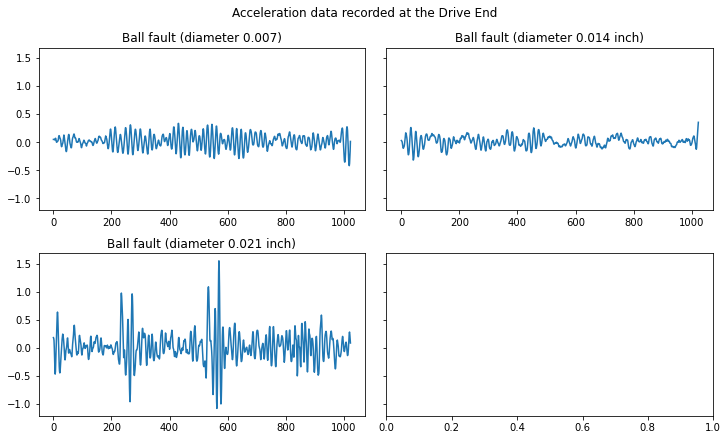

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

range_of_samples = range(0,1200)

# plotting
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Drive End')

axs[0, 0].plot(DF.iloc[1])
axs[0, 0].set_title('Ball fault (diameter 0.007)')

axs[0, 1].plot(DF.iloc[461])
axs[0, 1].set_title('Ball fault (diameter 0.014 inch)')

axs[1, 0].plot(DF.iloc[1381])
axs[1, 0].set_title('Ball fault (diameter 0.021 inch)')

In [20]:
# 'https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/CWRU_time_domain_data_preprocessing.ipynb'